# Part I: Profiling expression STRs across 17 human tissues

This notebook contains:

#### Supplementary Figures:
* **Supplementary Figure POPPCA**
* **Supplementary Figure PEER**

#### Statistics:
* Population breakdown of GTEx cohort
* How many STRs in all analyses

In [2]:
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "SuppFig"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data ################
pca = pd.read_csv(os.path.join(DATADIR, "GTEx_1KG_merged_650.pca.evec"), sep='\s+')
pca.columns = ["PC%s"%i for i in range(1, 11)] + ["pop"]
pca = pca.fillna({'pop':'1000Genomes'})

peerfactors = pd.read_csv(os.path.join(DATADIR, "AdiposePeerFactors.tsv"), sep="\t")
subject_cov = pd.read_csv("/storage/resources/datasets/gtex/59533/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v7.p2.c1.GRU/PhenotypeFiles/phs000424.v7.pht002742.v7.p2.c1.GTEx_Subject_Phenotypes.GRU.txt.gz", \
                   sep="\t", quotechar='"', skiprows=10, compression="gzip")
sample_cov = pd.read_csv("/storage/resources/datasets/gtex/59533/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v7.p2.c1.GRU/PhenotypeFiles/phs000424.v7.pht002743.v7.p2.c1.GTEx_Sample_Attributes.GRU.txt.gz", \
                   sep="\t", quotechar='"', skiprows=10, compression="gzip")

Populating the interactive namespace from numpy and matplotlib


In [5]:
%%bash -s "$DATADIR"

DATADIR=$1

# Population breakdown of GTEx cohort
cat ${DATADIR}/GTEx_1KG_merged_650.ind.poplabels | grep -v NA | cut -f 3 | sort | uniq -c

# Number of STRs included in analysis:
#zcat /storage/szfeupe/Runs/650GTEx_estr/Filter_Merged_STRs_All_Samples_New.vcf.gz | grep PASS | wc -l

     75 AfricanAmerican
      3 Amerindian
      8 Asian
    561 European
      5 Unknown


# Supplementary Figure POPPCA

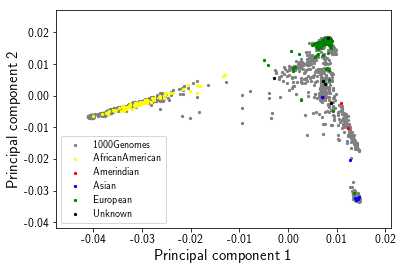

In [22]:
COLORS = {'AMR':'slategray', 
          'AFR':'gray',
          'EUR':'lightgray', 
          'EAS':'k', 
          'SAS':'lightslategrey', 
          'AfricanAmerican':'yellow', 
          'Asian':'blue', 
          'European':'green',
          'Amerindian':'red', 
          '1000Genomes':'grey',
          'Unknown':'k'
         }

fig, ax = plt.subplots()
grouped = pca.groupby('pop')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', marker='.', x='PC1', y='PC2', label=key, color=COLORS[key])

plt.legend(loc="lower left")
ax.set_xlabel("Principal component 1", size=15)
ax.set_ylabel("Principal component 2", size=15)
ax.set_xticklabels(["%.2f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_POPPCA.pdf"%FIGPREFIX))

# Supplementary Figure PEER

In [3]:
peerfactors.index = sorted([x.replace('.','-') for x in list(peerfactors.index)])
peerfactors["SUBJID"] = peerfactors.index
sample_cov["SUBJID"] = ['-'.join(x.split('-')[:2]) for x in list(sample_cov['SAMPID'])]
peerdata = pd.merge(peerfactors, subject_cov, on=["SUBJID"])
peerdata = pd.merge(sample_cov, peerdata, on=["SUBJID"])
peerdata = peerdata[peerdata["SMGEBTCH"].astype(str).apply(lambda x: "GTEx_" in x )]
peerdata = peerdata.groupby("SAMPID").first()

def GetCorr(pdata, column):
    usepeers = ["V%s"%i for i in range(2, 16)]
    return [scipy.stats.spearmanr(pdata[YY].values, pdata[column].values).correlation for YY in usepeers]

def Startswith(item, l):
    for sw in l:
        if item.startswith(sw): return True
    return False

In [4]:
cols = ["SEX","AGE","RACE","HGHT","BMI"] + [item for item in list(peerdata.columns) if Startswith(item, ["DTH","SM","MH","LB","TR"])] 
cols = list(set(cols))
dfdata = {}
for col in cols:
    try:
        cor = GetCorr(peerdata, col)
        dfdata[col] = cor
    except: continue

df = pd.DataFrame(dfdata)

/home/mgymrek/.local/lib/python2.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/home/mgymrek/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mgymrek/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/mgymrek/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mgymrek/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mgymrek/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastruct

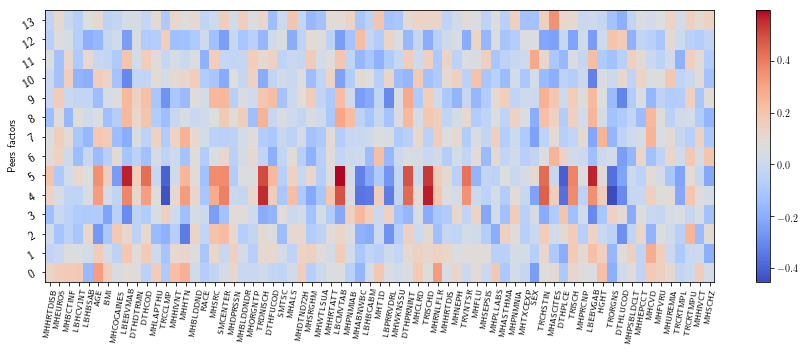

In [6]:
means = df.apply(np.mean)
plotcols = list(set(list(means[means.apply(abs)>0.02].index) + ["AGE","BMI","SEX","RACE","HGHT"]))

df_plot = df[plotcols]
fig, ax = plt.subplots(figsize=(15,5))

plt.pcolor(df_plot, cmap='coolwarm')

ax.set_xticks(np.arange(df_plot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(df_plot.shape[0]) + 0.5, minor=False)

labels = list(df_plot.columns)
ax.set_xticklabels(labels, rotation=80, size=8)
ax.set_yticklabels(df_plot.index,rotation=30, size=12)
plt.ylabel('Peers factors')
plt.colorbar()

plt.grid(False)

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_PEER.pdf"%FIGPREFIX))